# Dynamic Optimization and Reinforcement Learning
## Project: Stock Portfolio Optimization
## Assignment 3 - Project Phase 1
### Georgios Gialouris 2019030063
### Nikolaos Angelidis 2019030190

In [53]:
import numpy as np
from itertools import product
import random

########## Set up the MDP environment ##########

def get_state_space(n):
  combinations = list(product('HL', repeat=n))  # Generate all combinations of 'H' and 'L' of length n (number of stocks) with repetitions
  combinations = [''.join(comb) for comb in combinations]  # Convert tuples to strings
  # Prepend each combination with the numbers from 1 to n
  states = []
  for i in range(1, n + 1):
    for comb in combinations:
      states.append(f"{i}{comb}")
  return states

def get_action_space(n):
  actions = list(range(1, n + 1))
  return actions

def get_transition_probabilities(states, markov_chains_pr, n):
  # markov_chains_pr is an (n x 4) matrix, where rows represent the stocks and columns represent the probabilities (pHH, pHL, pLH, pLL) of the 2-state Markov chains
  num_states = len(states)
  trans_pr = np.zeros((num_states, num_states))
  for i, from_state in enumerate(states):
    for j, to_state in enumerate(states):
      trans_pr[i, j] = 1
      # Convert the state strings to lists of characters excluding the first one (i.e., which stock we are currently holding)
      for k, (from_markov_state, to_markov_state) in enumerate(zip(list(from_state)[-n:], list(to_state)[-n:])):
        if from_markov_state == 'H' and to_markov_state == 'H':
          trans_pr[i, j] *= markov_chains_pr[k, 0]  ## pHH
        elif from_markov_state == 'H' and to_markov_state == 'L':
          trans_pr[i, j] *= markov_chains_pr[k, 1]  ## pHL
        elif from_markov_state == 'L' and to_markov_state == 'H':
          trans_pr[i, j] *= markov_chains_pr[k, 2]  ## pLH
        elif from_markov_state == 'L' and to_markov_state == 'L':
          trans_pr[i, j] *= markov_chains_pr[k, 3]  ## pLL
  return trans_pr

def get_rewards(states, stock_gains, transaction_fee, n):
  # stock_gains is an (n x 2) matrix, where rows represent the stocks and columns represent the expected gains (rH, rL) of each stock depending on the state (H, L) of the Markov chain
  num_states = len(states)
  rewards = np.zeros((num_states, num_states))
  for i, from_state in enumerate(states):
    for j, to_state in enumerate(states):
      # Convert the state strings to lists of characters
      from_state_chars = list(from_state)
      to_state_chars = list(to_state)
      old_stock = int(from_state[:-n])
      new_stock = int(to_state[:-n])
      if new_stock == old_stock:  # Invest in the same stock
        if to_state_chars[new_stock] == 'H':
          rewards[i, j] = stock_gains[new_stock - 1, 0]  # rH
        elif to_state_chars[new_stock] == 'L':
          rewards[i, j] = stock_gains[new_stock - 1, 1]  # rL
      else:  # Switch stocks
        if to_state_chars[new_stock] == 'H':
          rewards[i, j] = stock_gains[new_stock - 1, 0] - transaction_fee  # rH - transaction_fee
        elif to_state_chars[new_stock] == 'L':
          rewards[i, j] = stock_gains[new_stock - 1, 1] - transaction_fee  # rL - transaction_fee
  return rewards

########## Implement Policy Iteration to find the optimal policy for this MDP ##########

def policy_iteration(states, actions, trans_pr, rewards, gamma = 0.9, epsilon = 1e-6):
  t = 0
  policy = {s: random.choice(actions) for s in states}  # Start by choosing an arbitrary policy
  is_stable = False     # Initialize the policy stability flag
  while not is_stable:  # Iteratively evaluate and improve the policy until convergence
    old_policy = policy.copy()  # Keep the old policy to compare it with the new one
    # Evaluate the current policy by computing its state value function (i.e., calculating the value of each state of the MDP given that policy)
    value_function = policy_evaluation(policy, states, trans_pr, rewards, gamma, epsilon)
    # Update the policy using the value function
    policy = policy_improvement(value_function, states, actions, trans_pr, rewards, gamma)
    t += 1
    if policy == old_policy:  # If the "improved" policy is exactly the same with the one in the previous step, then we have converged to the optimal policy
      is_stable = True
  # print(f"Converged after {t} iterations")  # Keep track of the number of (outer) iterations needed to converge
  return policy, value_function

def policy_evaluation(policy, states, trans_pr, rewards, gamma, epsilon):
  num_states = len(states)
  prev_val_func = np.zeros(num_states)  # Use for the value of the next state (i.e., V(s'))
  while True:  # Update the policy state value function until it converges
    value_function = np.zeros(num_states)
    for s, state in enumerate(states):  # Update the value of each state
      action = policy[state]  # Action chosen by the policy
      possible_new_s = [i for i, k in enumerate(states) if k.startswith(str(action))]  # List of possible new states (i.e., states whose first character corresponds to the chosen action)
      value_function[s] = sum(trans_pr[s, new_s] * (rewards[s, new_s] + gamma * prev_val_func[new_s]) for new_s in possible_new_s)  # Calculate one Bellman step
    if np.max(np.abs(prev_val_func - value_function)) < epsilon:  # If the new policy state value function estimate is close enough to the previous one, then it has converged
      break
    prev_val_func = value_function.copy()  # Freeze the new values (to be used as the next V(s'))
  return value_function

def policy_improvement(value_function, states, actions, trans_pr, rewards, gamma):
  num_states = len(states)
  num_actions = len(actions)
  Q = np.zeros((num_states, num_actions), dtype=np.float64)  # The expected reward from state 's' when we first choose action 'a' and then follow the policy
  # Find the best action to take in each state by using a one-step look-ahead
  for s in range(num_states):
    for a in actions:
      possible_new_s = [i for i, k in enumerate(states) if k.startswith(str(a))]  # List of possible new states (i.e., states whose first character corresponds to the chosen action)
      Q[s][a - 1] = sum(trans_pr[s, new_s] * (rewards[s, new_s] + gamma * value_function[new_s]) for new_s in possible_new_s)
  new_policy = {s: (np.argmax(Q[s_index]) + 1) for s_index, s in enumerate(states)}  # Improve the policy
  return new_policy


In [54]:
# Confirm that our Policy Iteration algorithm finds the optimal policy given the scenario of the midterm exam
N = 2  # Number of stocks
markov_chains_pr = np.array([[0.5, 0.5, 0.5, 0.5],  # Transition probabilities (pHH, pHL, pLH, pLL) of the 2-state Markov chain of stock 1
                             [0.9, 0.1, 0.1, 0.9]])  # Transition probabilities (pHH, pHL, pLH, pLL) of the 2-state Markov chain of stock 2
stock_gains = np.array([[0.1, -0.02],  # Expected gain (rH, rL) of stock 1 depending on the state (H, L) of the Markov chain
                        [0.05, 0.01]])  # Expected gain (rH, rL) of stock 2 depending on the state (H, L) of the Markov chain
transaction_fee = 0.01
gamma = 0  # Discount factor
epsilon = 1e-6  # Convergence error

states = get_state_space(N)
actions = get_action_space(N)
trans_pr = get_transition_probabilities(states, markov_chains_pr, N)
rewards = get_rewards(states, stock_gains, transaction_fee, N)
optimal_policy, optimal_val_func = policy_iteration(states, actions, trans_pr, rewards, gamma, epsilon)

print("State Space:", states)
print("Action Space:", actions)
print("Transition Probabilities:", trans_pr)
print("Rewards:", rewards)
print("Optimal Policy:", optimal_policy)
print("Optimal Value Function:", optimal_val_func)


State Space: ['1HH', '1HL', '1LH', '1LL', '2HH', '2HL', '2LH', '2LL']
Action Space: [1, 2]
Transition Probabilities: [[0.45 0.05 0.45 0.05 0.45 0.05 0.45 0.05]
 [0.05 0.45 0.05 0.45 0.05 0.45 0.05 0.45]
 [0.45 0.05 0.45 0.05 0.45 0.05 0.45 0.05]
 [0.05 0.45 0.05 0.45 0.05 0.45 0.05 0.45]
 [0.45 0.05 0.45 0.05 0.45 0.05 0.45 0.05]
 [0.05 0.45 0.05 0.45 0.05 0.45 0.05 0.45]
 [0.45 0.05 0.45 0.05 0.45 0.05 0.45 0.05]
 [0.05 0.45 0.05 0.45 0.05 0.45 0.05 0.45]]
Rewards: [[ 0.1   0.1  -0.02 -0.02  0.04  0.    0.04  0.  ]
 [ 0.1   0.1  -0.02 -0.02  0.04  0.    0.04  0.  ]
 [ 0.1   0.1  -0.02 -0.02  0.04  0.    0.04  0.  ]
 [ 0.1   0.1  -0.02 -0.02  0.04  0.    0.04  0.  ]
 [ 0.09  0.09 -0.03 -0.03  0.05  0.01  0.05  0.01]
 [ 0.09  0.09 -0.03 -0.03  0.05  0.01  0.05  0.01]
 [ 0.09  0.09 -0.03 -0.03  0.05  0.01  0.05  0.01]
 [ 0.09  0.09 -0.03 -0.03  0.05  0.01  0.05  0.01]]
Optimal Policy: {'1HH': 1, '1HL': 1, '1LH': 1, '1LL': 1, '2HH': 2, '2HL': 1, '2LH': 2, '2LL': 1}
Optimal Value Function:

## Question 1: Assume N = 2, γ = 0. Assume further that $r_1^H = 2r_2^H$. Find environment parameters (transition probabilities, $r_i^L$ and transaction fees) for which the optimal policy is to always stay with the stock you have. Confirm that your PI algorithm indeed finds this policy.

In [55]:
def check_if_policy_stayed(optimal_policy):
    for key, value in optimal_policy.items():
        if int(key[0]) != int(value):
            return False
    return True

### In this case we are testing where the transaction fee bound is. By keeping constant the probabilities and rewards that were used in the midterm exam, we came to the conclusion that for transaction fees higher than c = 0.26 the policy decides to always stay at the same stock.

In [56]:
N = 2  # Number of stocks
markov_chains_pr = np.array([[0.5, 0.5, 0.5, 0.5],      # Transition probabilities (pHH, pHL, pLH, pLL) of the 2-state Markov chain of stock 1
                             [0.9, 0.1, 0.1, 0.9]])     # Transition probabilities (pHH, pHL, pLH, pLL) of the 2-state Markov chain of stock 2
stock_gains = np.array([[0.1, -0.02],   # Expected gain (rH, rL) of stock 1 depending on the state (H, L) of the Markov chain
                        [0.05, 0.01]])  # Expected gain (rH, rL) of stock 2 depending on the state (H, L) of the Markov chain
gamma = 0                       # Discount factor
epsilon = 1e-6                  # Convergence error
states = get_state_space(N)     # State space
actions = get_action_space(N)   # Action space
trans_pr = get_transition_probabilities(states, markov_chains_pr, N) # Transition Probabilities

counter = 0
total_counter = 0
for c in np.arange(0, 1, 0.001):
    rewards = get_rewards(states, stock_gains, c, N)
    optimal_policy, optimal_val_func = policy_iteration(states, actions, trans_pr, rewards, gamma, epsilon)
    total_counter += 1
    if check_if_policy_stayed(optimal_policy):
        counter += 1
        # print(f"For c = {c}")
        # print("Optimal Policy:", optimal_policy)
        # print("Optimal Value Function:", optimal_val_func)
    else:
        print(f"For c = {c} Not stayed...")



print("Ended")
print(f"In total of {total_counter} c's, we stayed in the same for {counter}")

For c = 0.0 Not stayed...
For c = 0.001 Not stayed...
For c = 0.002 Not stayed...
For c = 0.003 Not stayed...
For c = 0.004 Not stayed...
For c = 0.005 Not stayed...
For c = 0.006 Not stayed...
For c = 0.007 Not stayed...
For c = 0.008 Not stayed...
For c = 0.009000000000000001 Not stayed...
For c = 0.01 Not stayed...
For c = 0.011 Not stayed...
For c = 0.012 Not stayed...
For c = 0.013000000000000001 Not stayed...
For c = 0.014 Not stayed...
For c = 0.015 Not stayed...
For c = 0.016 Not stayed...
For c = 0.017 Not stayed...
For c = 0.018000000000000002 Not stayed...
For c = 0.019 Not stayed...
For c = 0.02 Not stayed...
For c = 0.021 Not stayed...
For c = 0.022 Not stayed...
For c = 0.023 Not stayed...
For c = 0.024 Not stayed...
For c = 0.025 Not stayed...
For c = 0.026000000000000002 Not stayed...
Ended
In total of 1000 c's, we stayed in the same for 973


### In this example, we will be testing how the transition probabilities may affect the outcome of our policy and the bound for the transaction fee. We found out that by changing the value of the transition probabilities the bound for the transaction fee increased to 0.074. For c higher than 0.074 our optimal policy is to stay at the same stock.


In [61]:
N = 2           # Number of stocks
gamma = 0       # Discount factor
epsilon = 1e-6  # Convergence error
counter = 0
total_counter = 0
my_range = np.arange(0, 1, 0.001)
stock_gains = np.array([[0.1, -0.02],   # Expected gain (rH, rL) of stock 1 depending on the state (H, L) of the Markov chain
                        [0.05, 0.01]])  # Expected gain (rH, rL) of stock 2 depending on the state (H, L) of the Markov chain

states = get_state_space(N)             # State space
actions = get_action_space(N)           # Action space

for c in my_range:
    for PHH1, PLH1 in zip(np.arange(0.1, 1, 0.1), np.arange(0.1, 1, 0.1)):
        for PHH2, PLH2 in zip(np.arange(0.1, 1, 0.1), np.arange(0.1, 1, 0.1)):
            total_counter += 1
            markov_chains_pr = np.array([[PHH1, 1-PHH1, PLH1, 1-PLH1], [PHH2, 1-PHH2, PLH2, 1-PLH2]])
            trans_pr = get_transition_probabilities(states, markov_chains_pr, N)

            rewards = get_rewards(states, stock_gains, c, N)
            optimal_policy, optimal_val_func = policy_iteration(states, actions, trans_pr, rewards, gamma, epsilon)
            if check_if_policy_stayed(optimal_policy):
                counter += 1
                # print(f"For c = {c}")
                # print("Optimal Policy:", optimal_policy)
                # print("Optimal Value Function:", optimal_val_func)
            else:
                print(f"For {c=} {PHH1=}, {PLH1=}, PHL1={1-PHH1}, PLL1={1-PHH1} | {PHH2=}, {PLH2=}, PHL2={1-PHH2}, PLL2={1-PLH2} - Not stayed...")


print("Ended")
print(f"In total of {total_counter} c's, we stayed in the same for {counter}")

For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.1, PLH2=0.1, PHL2=0.9, PLL2=0.9 - Not stayed...
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.2, PLH2=0.2, PHL2=0.8, PLL2=0.8 - Not stayed...
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.30000000000000004, PLH2=0.30000000000000004, PHL2=0.7, PLL2=0.7 - Not stayed...
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.4, PLH2=0.4, PHL2=0.6, PLL2=0.6 - Not stayed...
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.5, PLH2=0.5, PHL2=0.5, PLL2=0.5 - Not stayed...
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.6, PLH2=0.6, PHL2=0.4, PLL2=0.4 - Not stayed...
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.7000000000000001, PLH2=0.7000000000000001, PHL2=0.29999999999999993, PLL2=0.29999999999999993 - Not stayed...
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.8, PLH2=0.8, PHL2=0.19999999999999996, PLL2=0.19999999999999996 - Not stayed...
For c=0.0 PHH1=0.1, PLH1=0

### We also tested an extreme case where the probability to stay on the low state of stock2 was very high (0.99) and also the reward had a high negative value (-0.5), to see how it would affect the bound of the transaction fee that our policy is to stay at the picked stock. The bound of the value c = 0.092, which was furthermore increased in comparison with the last example.


In [ ]:
markov_chains_pr = np.array([[0.5, 0.5, 0.5, 0.5],  # Transition probabilities (pHH, pHL, pLH, pLL) of the 2-state Markov chain of stock 1
                             [0.01, 0.99, 0.01, 0.99]])  # Transition probabilities (pHH, pHL, pLH, pLL) of the 2-state Markov chain of stock 2
stock_gains = np.array([[0.1, -0.02],  # Expected gain (rH, rL) of stock 1 depending on the state (H, L) of the Markov chain
                        [0.05, -0.5]])  # Expected gain (rH, rL) of stock 2 depending on the state (H, L) of the Markov chain

my_range = np.arange(0, 1, 0.001)
counter = 0
total_counter = 0
for c in my_range:
    total_counter += 1
    rewards = get_rewards(states, stock_gains, c, N)
    optimal_policy, optimal_val_func = policy_iteration(states, actions, trans_pr, rewards, gamma, epsilon)
    if check_if_policy_stayed(optimal_policy):
        counter += 1
        # print(f"For c = {c}")
        # print("Optimal Policy:", optimal_policy)
        # print("Optimal Value Function:", optimal_val_func)
    else:
        print(f"For c = {c} Not stayed...")

print("Ended")
print(f"In total of {total_counter} c's, we stayed in the same for {counter}")

For c = 0.0 Not stayed...
For c = 0.001 Not stayed...
For c = 0.002 Not stayed...
For c = 0.003 Not stayed...
For c = 0.004 Not stayed...
For c = 0.005 Not stayed...
For c = 0.006 Not stayed...
For c = 0.007 Not stayed...
For c = 0.008 Not stayed...
For c = 0.009000000000000001 Not stayed...
For c = 0.01 Not stayed...
For c = 0.011 Not stayed...
For c = 0.012 Not stayed...
For c = 0.013000000000000001 Not stayed...
For c = 0.014 Not stayed...
For c = 0.015 Not stayed...
For c = 0.016 Not stayed...
For c = 0.017 Not stayed...
For c = 0.018000000000000002 Not stayed...
For c = 0.019 Not stayed...
For c = 0.02 Not stayed...
For c = 0.021 Not stayed...
For c = 0.022 Not stayed...
For c = 0.023 Not stayed...
For c = 0.024 Not stayed...
For c = 0.025 Not stayed...
For c = 0.026000000000000002 Not stayed...
For c = 0.027 Not stayed...
For c = 0.028 Not stayed...
For c = 0.029 Not stayed...
For c = 0.03 Not stayed...
For c = 0.031 Not stayed...
For c = 0.032 Not stayed...
For c = 0.033 Not sta

### Lastly, for the first question we messed around with the values of the rewards and how they affected the bound for the transaction fee. We found that the bound has increased futher from the last example up to c=0.17 where the rewards for the specific c were r2h=0.14, r1h=0.28, r1l=-0.056, r2l=0.028.

In [ ]:
N = 2           # Number of stocks
gamma = 0       # Discount factor
epsilon = 1e-6  # Convergence error
counter = 0
total_counter = 0


states = get_state_space(N)             # State space
actions = get_action_space(N)           # Action space

for c in np.arange(0, 1, 0.01):
    for PHH1, PLH1 in zip(np.arange(0.1, 0.9, 0.1), np.arange(0.1, 0.9, 0.1)):
        for PHH2, PLH2 in zip(np.arange(0.1, 0.9, 0.1), np.arange(0.1, 0.9, 0.1)):
            for r2h in np.arange(0.01, 0.15, 0.01):
                r1h = 2*r2h
                r1l = -r1h/5
                r2l = r2h/5
                total_counter += 1
                stock_gains = np.array([[r1h, r1l],   # Expected gain (rH, rL) of stock 1 depending on the state (H, L) of the Markov chain
                                        [r2h, r2l]])  # Expected gain (rH, rL) of stock 2 depending on the state (H, L) of the Markov chain
                markov_chains_pr = np.array([[PHH1, 1-PHH1, PLH1, 1-PLH1], [PHH2, 1-PHH2, PLH2, 1-PLH2]])
                trans_pr = get_transition_probabilities(states, markov_chains_pr, N)

                rewards = get_rewards(states, stock_gains, c, N)
                optimal_policy, optimal_val_func = policy_iteration(states, actions, trans_pr, rewards, gamma, epsilon)
                if check_if_policy_stayed(optimal_policy):
                    counter += 1
                    # print(f"For c = {c}")
                    # print("Optimal Policy:", optimal_policy)
                    # print("Optimal Value Function:", optimal_val_func)
                else:
                    print(f"For {c=} {PHH1=}, {PLH1=}, PHL1={1-PHH1}, PLL1={1-PHH1} | {PHH2=}, {PLH2=}, PHL2={1-PHH2}, PLL2={1-PLH2} - | {r2h=}, {r1h=}, {r1l=}, {r2l=}")


print("Ended")
print(f"In total of {total_counter} c's, we stayed in the same for {counter}")

For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.1, PLH2=0.1, PHL2=0.9, PLL2=0.9 - | r2h=0.01, r1h=0.02, r1l=-0.004, r2l=0.002
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.1, PLH2=0.1, PHL2=0.9, PLL2=0.9 - | r2h=0.02, r1h=0.04, r1l=-0.008, r2l=0.004
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.1, PLH2=0.1, PHL2=0.9, PLL2=0.9 - | r2h=0.03, r1h=0.06, r1l=-0.012, r2l=0.006
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.1, PLH2=0.1, PHL2=0.9, PLL2=0.9 - | r2h=0.04, r1h=0.08, r1l=-0.016, r2l=0.008
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.1, PLH2=0.1, PHL2=0.9, PLL2=0.9 - | r2h=0.05, r1h=0.1, r1l=-0.02, r2l=0.01
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.1, PLH2=0.1, PHL2=0.9, PLL2=0.9 - | r2h=0.060000000000000005, r1h=0.12000000000000001, r1l=-0.024, r2l=0.012
For c=0.0 PHH1=0.1, PLH1=0.1, PHL1=0.9, PLL1=0.9 | PHH2=0.1, PLH2=0.1, PHL2=0.9, PLL2=0.9 - | r2h=0.06999999999999999, r1h=0.13999999999999999, r1l=-0.02799

## Question 2: Assume now γ = 0.9. Find environment parameters for which the optimal policy is in some states to switch and in some to stay. Confirm that your PI algorithm finds the optimal policy.

### For this question, we used the previous setup with only change for the value of the discount factor (γ) from 0 to 0.9. Fistly, this had the effect on the policy stabilization to be slower than the previous case since now our policy has to account for future rewards also and not just current ones. Secondly, after the execution of the code block below we understand that with the increase of the transaction fee the presence of our policy picking to stay for some stocks and to leave for others becomes much more probable. Lastly, we can also see that as the rewards of the stocks rise, the policy picks to stay in the current stock we get that from the logging having gaps, meaning that for high transaction costs it picks to stay at the same stock that has high reward.

In [10]:
N = 2               # Number of stocks
gamma = 0.9         # Discount factor
epsilon = 1e-6      # Convergence error
counter = 0
total_counter = 0
# In total of 89600 c's, we stayed in the same for 56742

states = get_state_space(N)             # State space
actions = get_action_space(N)           # Action space

for c in np.arange(0, 0.25, 0.01):
    for PHH1, PLH1 in zip(np.arange(0.1, 0.9, 0.1), np.arange(0.1, 0.9, 0.1)):
        for PHH2, PLH2 in zip(np.arange(0.1, 0.9, 0.1), np.arange(0.1, 0.9, 0.1)):
            for r2h in np.arange(0.01, 0.15, 0.01):
                r1h = 2*r2h
                r1l = -r1h/5
                r2l = r2h/5
                total_counter += 1
                stock_gains = np.array([[r1h, r1l],   # Expected gain (rH, rL) of stock 1 depending on the state (H, L) of the Markov chain
                                        [r2h, r2l]])  # Expected gain (rH, rL) of stock 2 depending on the state (H, L) of the Markov chain
                markov_chains_pr = np.array([[PHH1, 1-PHH1, PLH1, 1-PLH1], [PHH2, 1-PHH2, PLH2, 1-PLH2]])
                trans_pr = get_transition_probabilities(states, markov_chains_pr, N)

                rewards = get_rewards(states, stock_gains, c, N)
                optimal_policy, optimal_val_func = policy_iteration(states, actions, trans_pr, rewards, gamma, epsilon)
                if not check_if_policy_stayed(optimal_policy):
                    counter += 1
                    # print(f"For c = {c}")
                    # print("Optimal Policy:", optimal_policy)
                    # print("Optimal Value Function:", optimal_val_func)
                else:
                    print(f"{total_counter=} For {c=} {PHH1=}, {PLH1=}, PHL1={1-PHH1}, PLL1={1-PHH1} | {PHH2=}, {PLH2=}, PHL2={1-PHH2}, PLL2={1-PLH2} - | {r2h=}, {r1h=}, {r1l=}, {r2l=}")


print("Ended")
print(f"In total of {total_counter} c's, we stayed in the same for {counter}")

Streaming output truncated to the last 5000 lines.
total_counter=7569 For c=0.08 PHH1=0.4, PLH1=0.4, PHL1=0.6, PLL1=0.6 | PHH2=0.5, PLH2=0.5, PHL2=0.5, PLL2=0.5 - | r2h=0.09, r1h=0.18, r1l=-0.036, r2l=0.018
total_counter=7570 For c=0.08 PHH1=0.4, PLH1=0.4, PHL1=0.6, PLL1=0.6 | PHH2=0.5, PLH2=0.5, PHL2=0.5, PLL2=0.5 - | r2h=0.09999999999999999, r1h=0.19999999999999998, r1l=-0.039999999999999994, r2l=0.019999999999999997
total_counter=7571 For c=0.08 PHH1=0.4, PLH1=0.4, PHL1=0.6, PLL1=0.6 | PHH2=0.5, PLH2=0.5, PHL2=0.5, PLL2=0.5 - | r2h=0.11, r1h=0.22, r1l=-0.044, r2l=0.022
total_counter=7572 For c=0.08 PHH1=0.4, PLH1=0.4, PHL1=0.6, PLL1=0.6 | PHH2=0.5, PLH2=0.5, PHL2=0.5, PLL2=0.5 - | r2h=0.12, r1h=0.24, r1l=-0.048, r2l=0.024
total_counter=7573 For c=0.08 PHH1=0.4, PLH1=0.4, PHL1=0.6, PLL1=0.6 | PHH2=0.5, PLH2=0.5, PHL2=0.5, PLL2=0.5 - | r2h=0.13, r1h=0.26, r1l=-0.052000000000000005, r2l=0.026000000000000002
total_counter=7574 For c=0.08 PHH1=0.4, PLH1=0.4, PHL1=0.6, PLL1=0.6 | PHH2=0.5

## Question 3: Implement now a generic scenario where, for every stock $r_i^H$, $r_i^L$ are chosen uniformly in [-0.02, +0.1], and transition probabilities, $p_{HL}^i$, $p_{LH}^i$ are equal to 0.1 for half the stocks and 0.5 for the other half. Try to increase N to the largest scenario you can solve in less than 1h in Colab? Show and interpret your results.

### get_rewards_uniformally(N) : N amount of stocks
- returns the high and low rewards chosen uniformally for each stock


### get_markov_chains_pr(N) : N amount of stocks
- returns transition probabilities for the stocks as requested byt the question


In [60]:
def get_rewards_uniformally(n):
    result = []
    for i in range(n):
        value1 = random.uniform(-0.02, 0.1)
        value2 = random.uniform(-0.02, 0.1)
        if value1>value2:
            result.append([value1, value2])
        else:
            result.append([value2, value1])

    return np.array(result)

def get_markov_chains_pr(n):
    result = []
    for i in range(n):
        if i%2==0:
            result.append([0.9, 0.1, 0.1, 0.9])
        else:
            result.append([0.5, 0.5, 0.5, 0.5])

    return np.array(result)

### First of all, because of the uniformally generated rewards for each stock, the discount factor (γ) does not have much impact on the outcome of the algorithm. For the number of stocks we have concluded that up to N = 8, the execution time in Google Colab seems to be fast, under 12 minutes. After that with each further addition of a new stock the computational time increases exponentially  surpassing 1 hour easily. Therefore, our policy iteration algorithm for MDP problems seems to have a computational threshold and depends on the number of stocks.

In [59]:
N = 8  # Number of stocks

markov_chains_pr = get_markov_chains_pr(N)
stock_gains = get_rewards_uniformally(N)

# print(markov_chains_pr)
# print(stock_gains)

gamma = 0.9             # Discount factor
epsilon = 1e-6          # Convergence error
transaction_fee = 0.01  # Transaction fee

states = get_state_space(N)
actions = get_action_space(N)
trans_pr = get_transition_probabilities(states, markov_chains_pr, N)
rewards = get_rewards(states, stock_gains, transaction_fee, N)
optimal_policy, optimal_val_func = policy_iteration(states, actions, trans_pr, rewards, gamma, epsilon)

# print("State Space:", states)
# print("Action Space:", actions)
# print("Transition Probabilities:", trans_pr)
# print("Rewards:", rewards)
print("Optimal Policy:", optimal_policy)
print("Optimal Value Function:", optimal_val_func)

Optimal Policy: {'1HHHHHHHH': 5, '1HHHHHHHL': 5, '1HHHHHHLH': 5, '1HHHHHHLL': 5, '1HHHHHLHH': 5, '1HHHHHLHL': 5, '1HHHHHLLH': 5, '1HHHHHLLL': 5, '1HHHHLHHH': 2, '1HHHHLHHL': 2, '1HHHHLHLH': 2, '1HHHHLHLL': 2, '1HHHHLLHH': 2, '1HHHHLLHL': 2, '1HHHHLLLH': 2, '1HHHHLLLL': 2, '1HHHLHHHH': 5, '1HHHLHHHL': 5, '1HHHLHHLH': 5, '1HHHLHHLL': 5, '1HHHLHLHH': 5, '1HHHLHLHL': 5, '1HHHLHLLH': 5, '1HHHLHLLL': 5, '1HHHLLHHH': 2, '1HHHLLHHL': 2, '1HHHLLHLH': 2, '1HHHLLHLL': 2, '1HHHLLLHH': 2, '1HHHLLLHL': 2, '1HHHLLLLH': 2, '1HHHLLLLL': 2, '1HHLHHHHH': 5, '1HHLHHHHL': 5, '1HHLHHHLH': 5, '1HHLHHHLL': 5, '1HHLHHLHH': 5, '1HHLHHLHL': 5, '1HHLHHLLH': 5, '1HHLHHLLL': 5, '1HHLHLHHH': 2, '1HHLHLHHL': 2, '1HHLHLHLH': 2, '1HHLHLHLL': 2, '1HHLHLLHH': 2, '1HHLHLLHL': 2, '1HHLHLLLH': 2, '1HHLHLLLL': 2, '1HHLLHHHH': 5, '1HHLLHHHL': 5, '1HHLLHHLH': 5, '1HHLLHHLL': 5, '1HHLLHLHH': 5, '1HHLLHLHL': 5, '1HHLLHLLH': 5, '1HHLLHLLL': 5, '1HHLLLHHH': 2, '1HHLLLHHL': 2, '1HHLLLHLH': 2, '1HHLLLHLL': 2, '1HHLLLLHH': 2, '1HHLLL

### For the above codeblock, we also run the algorithm for N=10 that went over the 1 hour limit and we decided to stop it there.

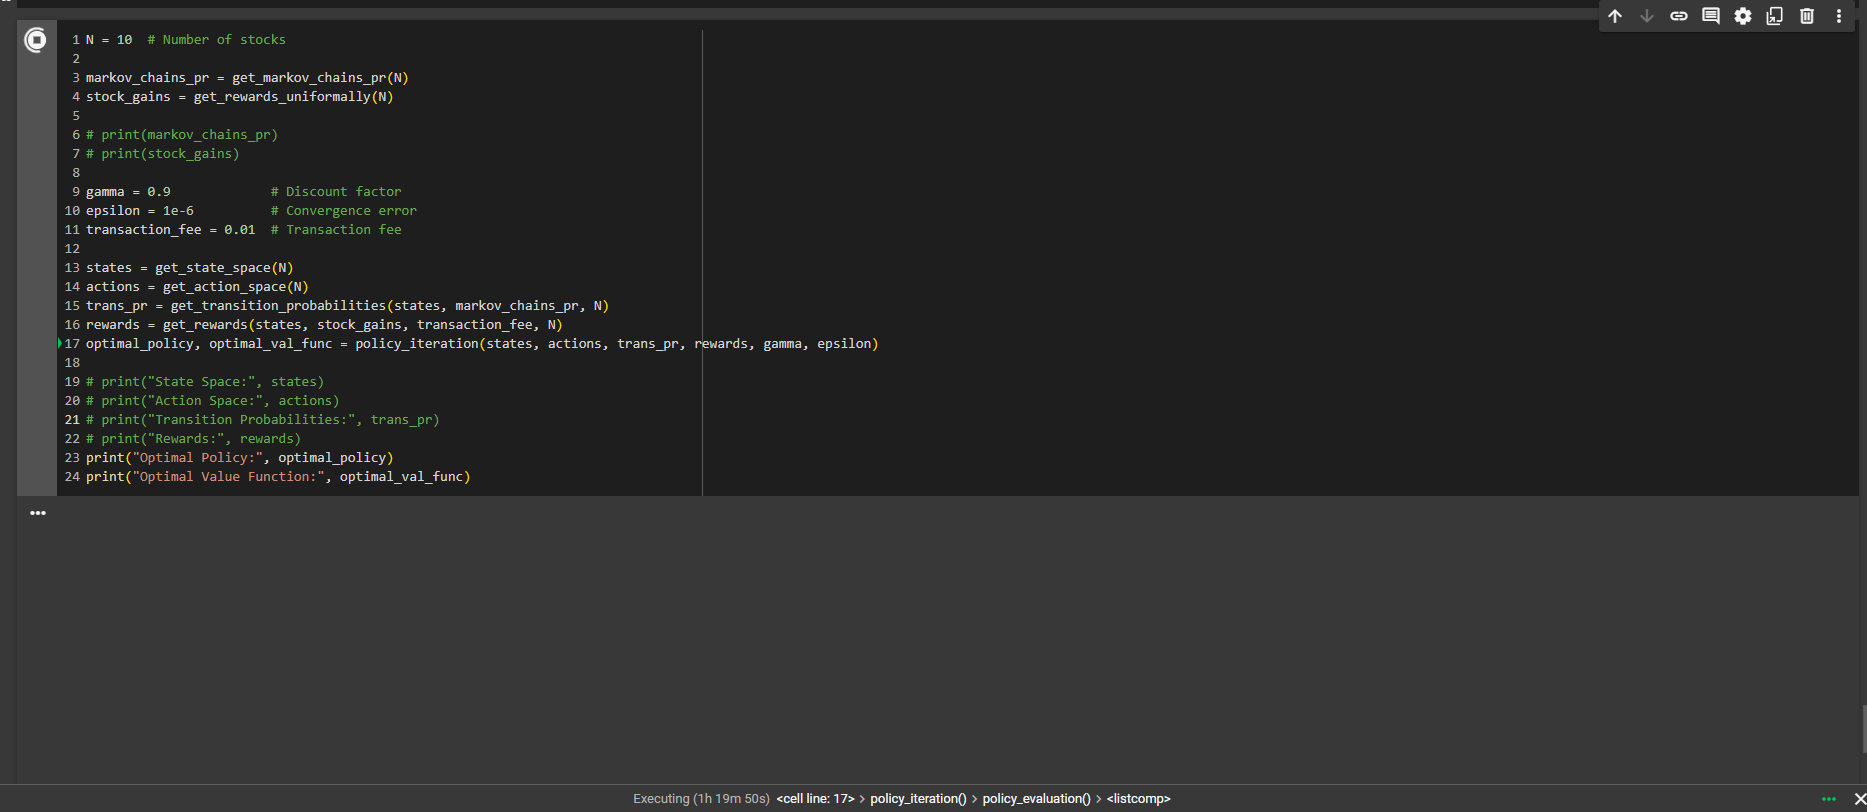